In [1]:
import pandas as pd
import numpy as np
import haversine as hs
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime
from datetime import date, timedelta
import copy

In [2]:
def load_tremor(file_name):
#load/reformat tremor files
    tremor_df = pd.read_csv(file_name)
    tremor_df.columns = ['lat','lon','depth','date']
    tremor_df['date']=pd.to_datetime(tremor_df['date'])
    tremor_df['date']=tremor_df['date'].dt.date
    
    return tremor_df

In [47]:
#load and combine tremor files

# tremor_df = pd.read_csv('brud_tremor', delim_whitespace= True,
#                         names = ['lon', 'lat','dist1','dist2','dec_time','date'])
# tremor_df.drop(columns = ['dist2','dec_time'], inplace = True)
# tremor_df['date'] = pd.to_datetime(tremor_df['date'], unit = 's').dt.date
# tremor_df['date'] = pd.to_datetime(tremor_df['date'])
# tremor_df = tremor_df[['lat', 'lon','dist1','date']]

trem_12 = load_tremor('tremor_events2012.csv')
trem_13 = load_tremor('tremor_events2013.csv')
trem_14 = load_tremor('tremor_events2014.csv')
trem_15 = load_tremor('tremor_events2015.csv')
trem_16 = load_tremor('tremor_events2016.csv')
trem_17 = load_tremor('tremor_events2017.csv')
trem_18 = load_tremor('tremor_events2018.csv')
trem_19 = load_tremor('tremor_events2019.csv')
trem_20 = load_tremor('tremor_events2020.csv')
trem_21 = load_tremor('tremor_events2021.csv')

tremor_df = pd.concat([trem_12, trem_13, trem_14, trem_15, trem_16])

#load station lat lon file and coastline file
location_df = pd.read_csv('station_lon_lat', delim_whitespace=True, header=None, names=['name','lon','lat'])
coast_df = pd.read_csv('PNWcoast.dat',delim_whitespace=True, header=None, names=['lon', 'lat'])

In [4]:
def get_counts(start, end, nearby_tremor):
#create timeline dataframe, which has all dates between the starting and end date 
#and the number of nearby tremor counts for each day

    date_rng=pd.date_range(start=start, end=end, freq='D')
    timeline=pd.DataFrame(date_rng, columns=['date'])
    timeline['date'] = timeline['date'].dt.date
    timeline['counts'] = 0

    date_counts = nearby_tremor.groupby(['date']).count()
    date_counts.reset_index(inplace=True)
    date_counts = date_counts.drop(['lat','lon','distance'], axis=1)
    date_counts.columns=['date','count']
    
    for index, row in date_counts.iterrows():
        idx = np.where(timeline['date'] == row['date'])
        timeline.iloc[idx[0][0],timeline.columns.get_loc('counts')] = row['count']
    
    return timeline

In [56]:
def get_dates(tremor, GPS, start_date, end_date, buffer):
#Determine the starting and ending dates for the GPS data according to the tremor.
#This function finds the date of maximum value for the STA/LTA ratio, and then moves out in each 
#direction (before/after event) until the ratio drops below 0.5. 
#If the GPS time series does not have data within 10 days of the end/starting date, then the
#loop breaks and the dates get a default value. 

    mask = (tremor['date'] >= (start_date + timedelta(days=buffer))) & (tremor['date'] <= (end_date - timedelta(days=buffer)))
    tmp_tremor = tremor.loc[mask]
    
    #lower this limit if using brudzinski catalog from 100
    if tmp_tremor['counts'].max() == 0 or tmp_tremor['counts'].max() < 100 :
        start_idx=[0]
        end_idx=[0]
        n_start=[0]
        n_end=[0]
    else:

        n_start = tmp_tremor['ratio'].idxmax(skipna=True)
        ratio = 1

        while ratio > 0.5:
            n_start -= 1
            ratio = tremor['ratio'].iloc[n_start]

        n_end = tmp_tremor['ratio'].idxmax(skipna=True)
        ratio = 1

        while ratio > 0.5:
            n_end += 1
            ratio = tremor['ratio'].iloc[n_end]

        start_idx = GPS_df.index[GPS_df['date']==(tremor['date'].loc[n_start])].tolist()
        end_idx = GPS_df.index[GPS_df['date']==(tremor['date'].loc[n_end])].tolist()

        n=1

        while np.size(start_idx) == 0:
            start_idx = GPS_df.index[GPS_df['date']==(tremor['date'].loc[n_start - n])].tolist()
            n += 1
            if n > 10:
                start_idx=[1]
                end_idx=[1]
                break
        n=1

        while np.size(end_idx) == 0:
            end_idx = GPS_df.index[GPS_df['date']==(tremor['date'].loc[n_end + n])].tolist()
            n += 1
            if n > 10:
                start_idx=[1]
                end_idx=[1]
                break
       
    return n_start, n_end, start_idx, end_idx

In [148]:
buffer=30

#Brudzinsky Catalog

# start_date=pd.to_datetime(date(2007,2,7) - timedelta(days=buffer))  #   2007 February - buffer 60
# end_date=pd.to_datetime(date(2007,2,25) + timedelta(days=buffer))   #                tremor limit 10

# start_date=pd.to_datetime(date(2007,7,15) - timedelta(days=buffer))  # 2007 July - buffer 60
# end_date=pd.to_datetime(date(2007,8,7) + timedelta(days=buffer))    #              tremor limit 20

# start_date=pd.to_datetime(date(2008,4,1) - timedelta(days=buffer))  #   2008 April - buffer 60
# end_date=pd.to_datetime(date(2008,5,10) + timedelta(days=buffer))   #                tremor limit 10

# start_date=pd.to_datetime(date(2008,11,1) - timedelta(days=buffer))  #   2008 November - buffer 60 
# end_date=pd.to_datetime(date(2009,1,1) + timedelta(days=buffer))   #                     tremor limit 10

# start_date=pd.to_datetime(date(2009,3,9) - timedelta(days=buffer))  #   2009 March - buffer 60
# end_date=pd.to_datetime(date(2009,3,20) + timedelta(days=buffer))   #                tremor limit 10

# start_date=pd.to_datetime(date(2010,11,13) - timedelta(days=buffer))  #   2010 November - buffer 60
# end_date=pd.to_datetime(date(2010,12,5) + timedelta(days=buffer))   #                     tremor limit 10

# PNSN Catalog

#start_date=pd.to_datetime(date(2012,2,5) - timedelta(days=buffer))  #   2012 February - buffer 25
#end_date=pd.to_datetime(date(2012,2,20) + timedelta(days=buffer))   #                   tremor limit 100

# start_date=pd.to_datetime(date(2012,10,15) - timedelta(days=buffer))  #   2012 February - buffer 30
# end_date=pd.to_datetime(date(2012,11,9) + timedelta(days=buffer))   #                   tremor limit 100

start_date=pd.to_datetime(date(2014,8,16) - timedelta(days=buffer))  #   2014 August - buffer 30
end_date=pd.to_datetime(date(2014,9,24) + timedelta(days=buffer))   #                  tremor limit 100

# start_date=pd.to_datetime(date(2019,2,24) - timedelta(days=buffer))  #2019 March1 - buffer 60
# end_date=pd.to_datetime(date(2019,3,15) + timedelta(days=buffer))    #           +

#start_date=pd.to_datetime(date(2019,3,20) - timedelta(days=buffer))  #2019 March2 - buffer 60
#end_date=pd.to_datetime(date(2019,4,5) + timedelta(days=buffer))

#start_date=pd.to_datetime(date(2019,11,17) - timedelta(days=buffer))  #2019 November - buffer 60
#end_date=pd.to_datetime(date(2019,12,5) + timedelta(days=buffer))     #           +

#start_date=pd.to_datetime(date(2019,12,10) - timedelta(days=buffer))  #2019 December - buffer 60
#end_date=pd.to_datetime(date(2020,1,5) + timedelta(days=buffer))

# start_date=pd.to_datetime(date(2020,6,15) - timedelta(days=buffer))  #2020 July, buffer 30
# end_date=pd.to_datetime(date(2020,7,12) + timedelta(days=buffer))

# start_date=pd.to_datetime(date(2021,3,7) - timedelta(days=buffer))  # 2021 March, v beginning of v large event
# end_date=pd.to_datetime(date(2021,3,19) + timedelta(days=buffer))   # beware of common mode... buffer 30

station_dates=pd.DataFrame(columns=('Name','Data Available','Lat','Lon','Start Date','End Date'))

for index, row in location_df.iterrows():
    
    #Get station position and load GPS file
    station_pos = (location_df['lat'].iloc[index],location_df['lon'].iloc[index])
    file = location_df['name'].iloc[index] + '_cleaned.txt'
    GPS_df = pd.read_csv(file, header=None, delim_whitespace=True, names=['date','date time','N','E','U',
                                                                                       'sN','sE','sU'])
    GPS_df['date']=pd.to_datetime(GPS_df['date'])
    GPS_df['date']=GPS_df['date'].dt.date
    GPS_df.drop('date time', axis=1, inplace=True)

    #add column for distance between station and tremor
    tremor_df['distance'] = tremor_df.apply(lambda row: hs.haversine((row.lat,row.lon),station_pos), axis=1)

    #only keep tremor within 50km of the station
    close_tremor = tremor_df[tremor_df['distance'] < 50]

    #only keep tremor and GPS within a month of either end of the time window
    mask = (close_tremor['date'] >= start_date) & (close_tremor['date'] <= end_date)
    close_tremor = close_tremor.loc[mask]

    mask = (GPS_df['date'] >= start_date) & (GPS_df['date'] <= end_date)
    GPS_df = GPS_df.loc[mask]

    #create full timeline with tremor counts and calculate STA/LTA ratio
    timeline = get_counts(start_date, end_date, close_tremor)
    timeline['ratio'] = timeline['counts'].rolling(7, center=True).mean()/timeline['counts'].rolling(56, center=True).mean()
    
    #default date is my birthday :) 
    default_date = datetime.datetime(1991,12,10).date()
    
    #If GPS time series has less than 50 data points, then it is not considered 
    if len(GPS_df.index) < 50:
        print('Not Enough GPS data for station ' + location_df['name'].iloc[index])
        station_dates.loc[index] =[location_df['name'].iloc[index],'No',
                                   location_df['lat'].iloc[index],location_df['lon'].iloc[index],
                                   default_date, default_date]
        plt.figure(figsize=(10,10))
        ax = plt.subplot(2,1,1)
        ax.plot(GPS_df['date'],GPS_df['E'],'.')
        ax.set_xlabel('Time')
        ax.set_ylabel('E Displacement')
            
        ax = plt.subplot(2,1,2)
        ax.plot(GPS_df['date'],GPS_df['N'],'.')
        ax.set_xlabel('Time')
        ax.set_ylabel('N Displacement')
    
    else:
        trem_start_idx, trem_end_idx, GPS_start_idx, GPS_end_idx = get_dates(timeline, GPS_df, start_date, end_date, buffer)
    
        #Station with not enough data around the event or not close enough to tremor are given default dates
        if GPS_start_idx[0] == 1:
            print('Not Enough Data around event for station ' + location_df['name'].iloc[index])   
            station_dates.loc[index] =[location_df['name'].iloc[index],'No',
                                   location_df['lat'].iloc[index],location_df['lon'].iloc[index],
                                   default_date, default_date]
        elif GPS_start_idx[0] == 0:
            print('Not Close Enough to Tremor for station ' + location_df['name'].iloc[index])
            station_dates.loc[index] =[location_df['name'].iloc[index],'Yes',
                                   location_df['lat'].iloc[index],location_df['lon'].iloc[index],
                                   default_date, default_date]
            
        else:    
            print(location_df['name'].iloc[index]) 
            station_dates.loc[index] =[location_df['name'].iloc[index],'Yes',
                                       location_df['lat'].iloc[index],location_df['lon'].iloc[index],
                                       GPS_df['date'].loc[GPS_start_idx].values[0], 
                                       GPS_df['date'].loc[GPS_end_idx].values[0]]
            #plotting
            plt.figure(figsize=(20,10))
            ax1 = plt.subplot(1,2,1)

            ax1.plot(coast_df['lon'],coast_df['lat'])
            ax1.plot([-124.2,-120],[42,42])
            ax1.axis('equal')
            ax1.set_xlim(-126,-121)
            ax1.set_ylim(39,45)
            ax1.plot(close_tremor['lon'],close_tremor['lat'],'b.')
            ax1.plot(station_pos[1],station_pos[0],'ro')

            ax2 = plt.subplot(3,2,2)
            ax22 = ax2.twinx()
            ax2.plot(timeline['date'],timeline['counts'])
            ax22.plot(timeline['date'],timeline['ratio'],'r')
            ax22.plot(timeline['date'].iloc[trem_start_idx], timeline['ratio'].iloc[trem_start_idx],'y*')
            ax22.plot(timeline['date'].iloc[trem_end_idx], timeline['ratio'].iloc[trem_end_idx],'y*')
            ax2.set_ylabel('Tremor Count')
            ax2.set_title(location_df['name'].iloc[index])

            ax3 = plt.subplot(3,2,4)
            ax3.plot(GPS_df['date'],GPS_df['E'],'.')
            ax3.set_xlabel('Time')
            ax3.set_ylabel('E Displacement')
            ax3.plot(GPS_df['date'].loc[GPS_start_idx], GPS_df['E'].loc[GPS_start_idx],'y*')
            ax3.plot(GPS_df['date'].loc[GPS_end_idx], GPS_df['E'].loc[GPS_end_idx],'y*')
            
            ax4 = plt.subplot(3,2,6)
            ax4.plot(GPS_df['date'],GPS_df['N'],'.')
            ax4.set_xlabel('Time')
            ax4.set_ylabel('N Displacement')
            ax4.plot(GPS_df['date'].loc[GPS_start_idx], GPS_df['N'].loc[GPS_start_idx],'y*')
            ax4.plot(GPS_df['date'].loc[GPS_end_idx], GPS_df['N'].loc[GPS_end_idx],'y*')


    #plt.show()
    #input("Enter")  #option to have the code pause for each station and require the user to press "enter" to continue
    #clear_output()
    plt.close()
    
plt.close('all')

Not Close Enough to Tremor for station CABL
Not Close Enough to Tremor for station DDSN
Not Close Enough to Tremor for station HCRO
Not Close Enough to Tremor for station LFLO
Not Close Enough to Tremor for station MDMT
Not Close Enough to Tremor for station MODB
Not Close Enough to Tremor for station P017
Not Close Enough to Tremor for station P058
P060
Not Close Enough to Tremor for station P061
Not Close Enough to Tremor for station P062
Not Close Enough to Tremor for station P148
Not Close Enough to Tremor for station P151
P154
P155
Not Close Enough to Tremor for station P156
Not Close Enough to Tremor for station P157
Not Close Enough to Tremor for station P158
Not Close Enough to Tremor for station P159
Not Close Enough to Tremor for station P161
Not Close Enough to Tremor for station P162
Not Close Enough to Tremor for station P163
Not Close Enough to Tremor for station P164
Not Close Enough to Tremor for station P165
Not Close Enough to Tremor for station P166
Not Close Enough 

In [149]:
#Create dataframe filled with stations that have valid dates, i.e. are close enough to tremor and have enough data
#to generate dates. 

mask = station_dates['Start Date'] != datetime.datetime(1991,12,10).date()
stations_with_dates = station_dates.loc[mask]
stations_with_dates = stations_with_dates.reset_index()
stations_with_dates['Distance']= ""

#For stations with data but without valid dates, find closest station according to latitude with valid dates
#and assign those dates
for index, row in station_dates.iterrows():
    
    if (row['Data Available'] == 'Yes') and (row['Start Date'] == datetime.datetime(1991,12,10).date()):
        
        stations_with_dates['Distance'] = stations_with_dates.apply(lambda row: abs(row['Lat']-location_df['lat'].iloc[index]), axis=1)
        idx = stations_with_dates['Distance'].idxmin()
        station_dates.loc[index,'Start Date'] = station_dates['Start Date'].iloc[stations_with_dates['index'].iloc[idx]]
        station_dates.loc[index,'End Date'] = station_dates['End Date'].iloc[stations_with_dates['index'].iloc[idx]]

(39.0, 45.0)

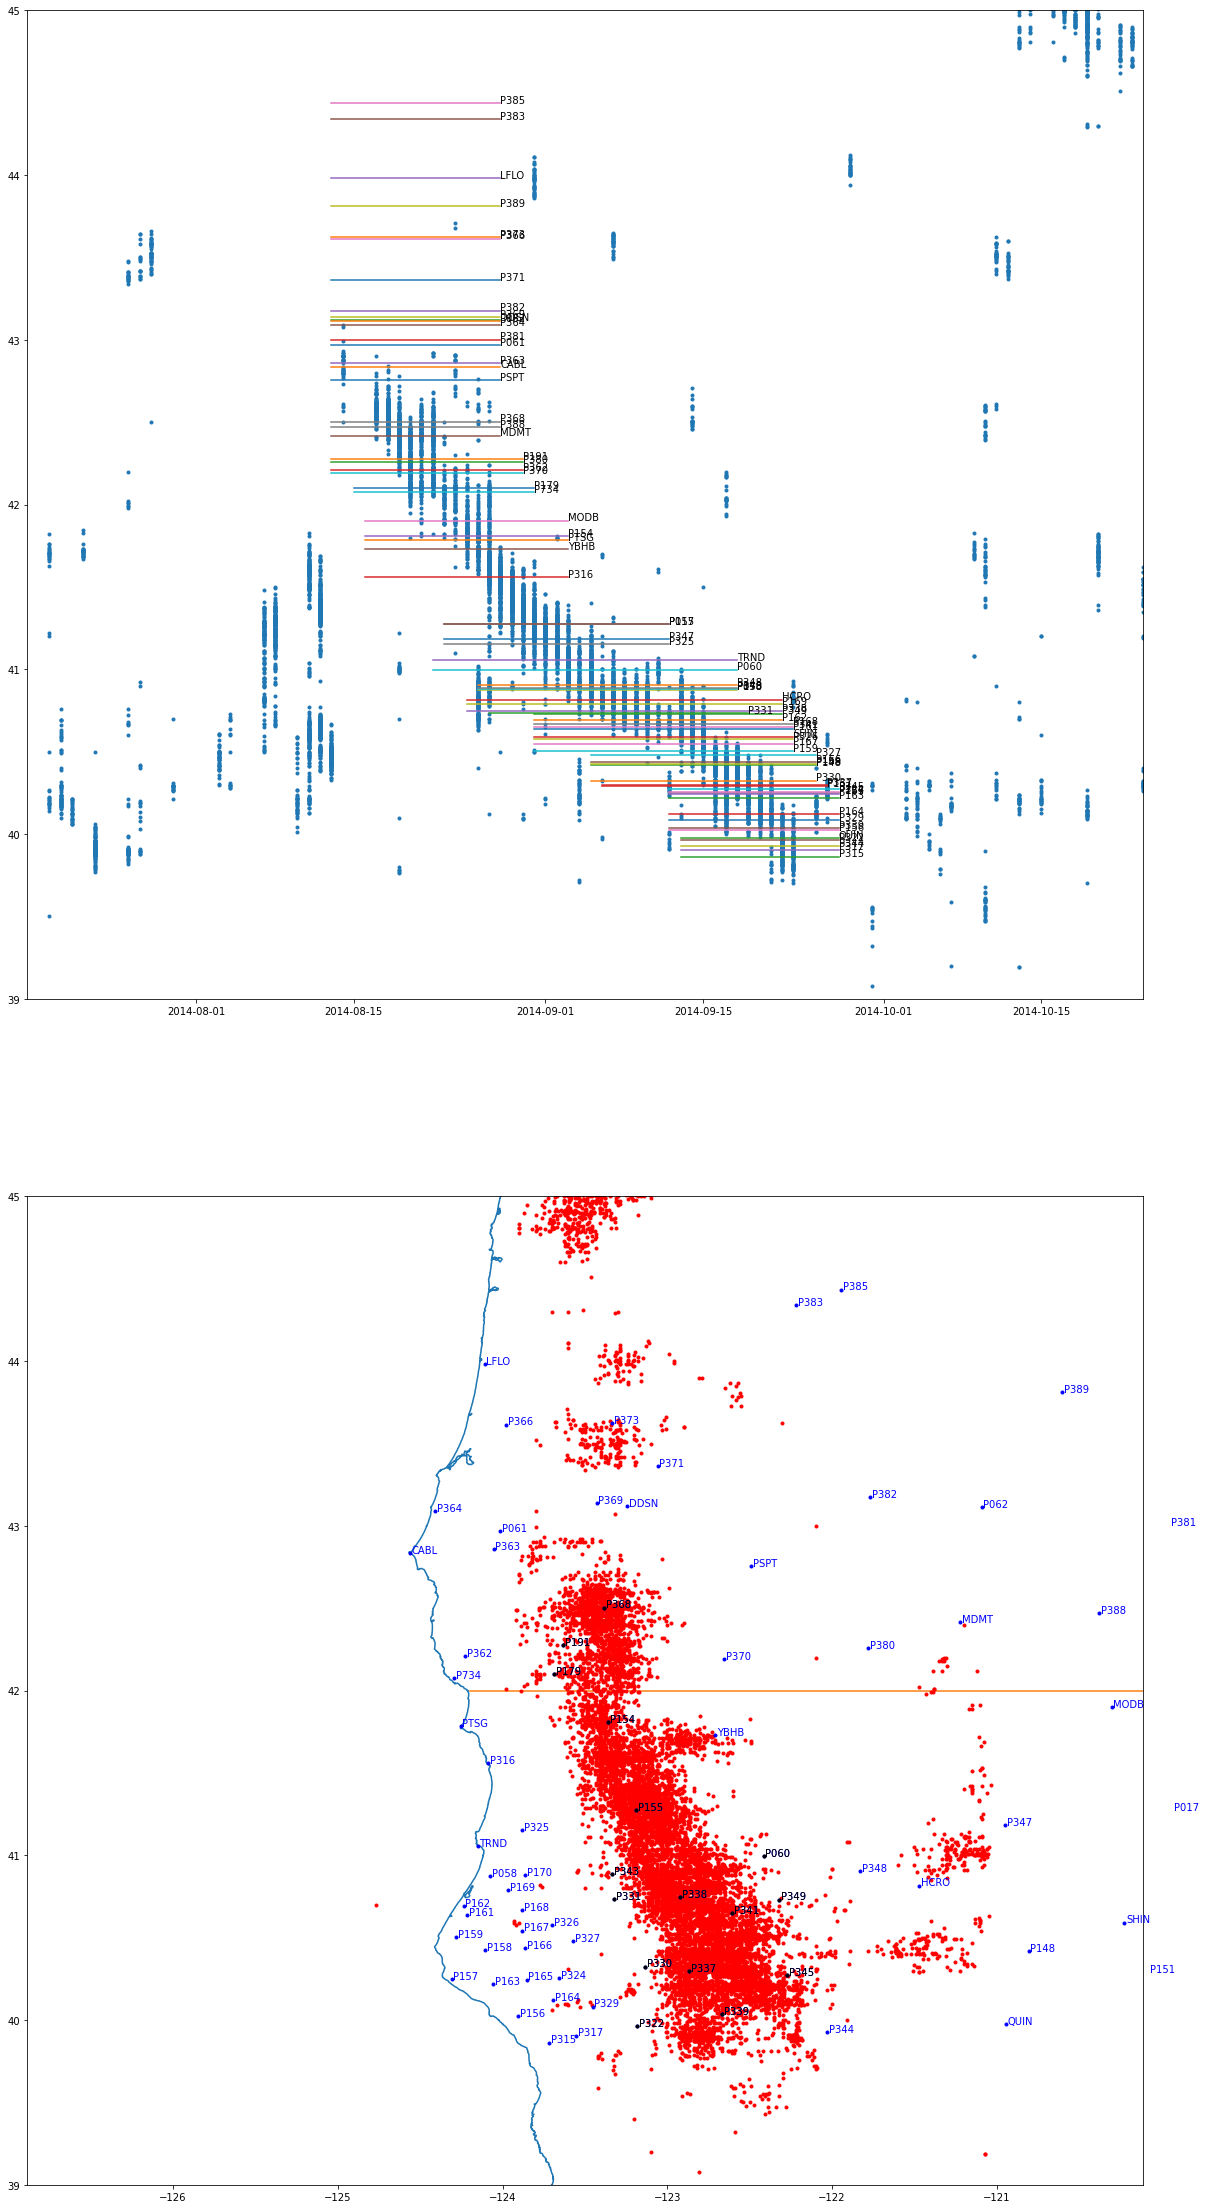

In [150]:
plt.figure(figsize=(20,40))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

ax1.plot(tremor_df['date'],tremor_df['lat'],'.')

mask = (tremor_df['date'] >= (start_date - timedelta(days=buffer))) & (tremor_df['date'] <= (end_date+timedelta(days=buffer)))
        
close_tremor = tremor_df.loc[mask]
    
ax2.plot(coast_df['lon'],coast_df['lat'])
ax2.plot([-124.2,-120],[42,42])
ax2.axis('equal')
ax2.set_xlim(-126,-121)
ax2.set_ylim(39,45)
ax2.plot(close_tremor['lon'],close_tremor['lat'],'r.')

for index, row in station_dates.iterrows():
    
    if row['Data Available'] == 'Yes':
        x = [row['Start Date'], row['End Date']]
        y = [row['Lat'], row['Lat']]
        ax1.plot(x,y)
        ax1.text(row['End Date'],row['Lat'],row['Name'])
        ax2.plot(row['Lon'],row['Lat'],'b.')
        ax2.text(row['Lon']+0.01,row['Lat'],row['Name'],color='b')
        
for index, row in stations_with_dates.iterrows():
    
    if row['Data Available'] == 'Yes':
        ax2.plot(row['Lon'],row['Lat'],'k.')
        ax2.text(row['Lon']+0.01,row['Lat'],row['Name'],color='k')


ax1.set_xlim(start_date, end_date)
ax1.set_ylim(39, 45)

In [151]:
station_dates.to_csv('2014_aug.csv', index=False)

In [19]:
tremor_df.head()

,lat,lon,date,distance
0,40.2608,-122.8359,2005-09-01,163.888907
1,40.3223,-122.8553,2005-09-02,157.181911
2,40.2065,-122.8419,2005-09-02,169.946984
3,40.2073,-122.7460,2005-09-02,169.526774
4,40.3913,-122.9518,2005-09-04,150.404984


(array(16436.), array(16801.))

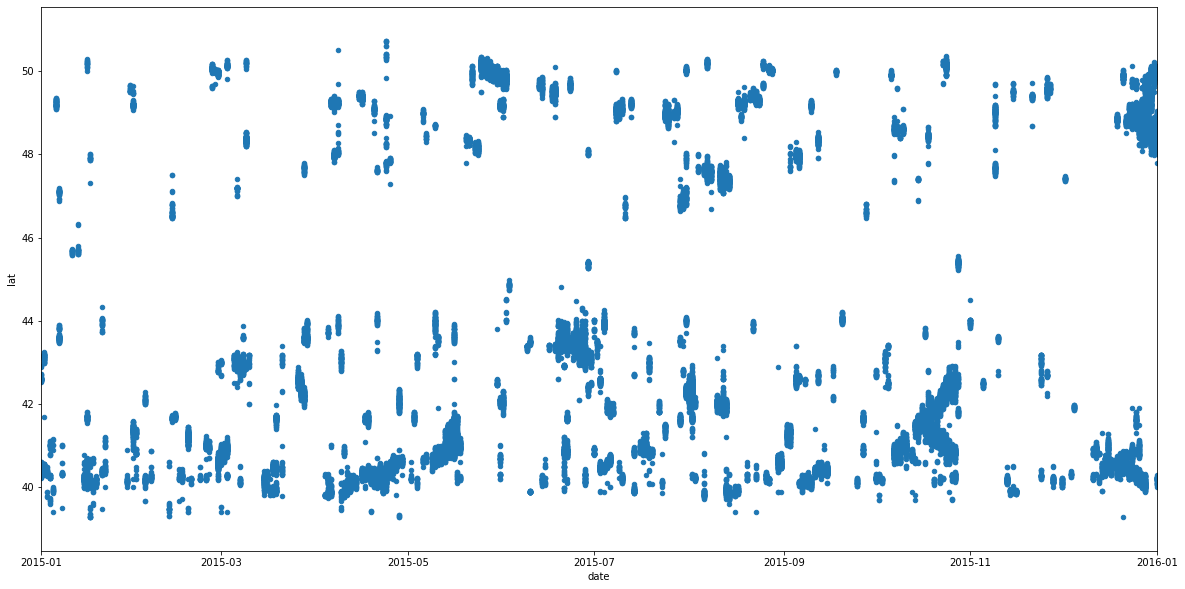

In [153]:
fig, ax = plt.subplots(figsize=(20,10))
tremor_df.plot.scatter(x='date',y='lat', ax = ax)
ax.set_xlim(['2015-01-01','2016-01-01'])
